100%|██████████| 10000/10000 [00:01<00:00, 7169.12it/s]


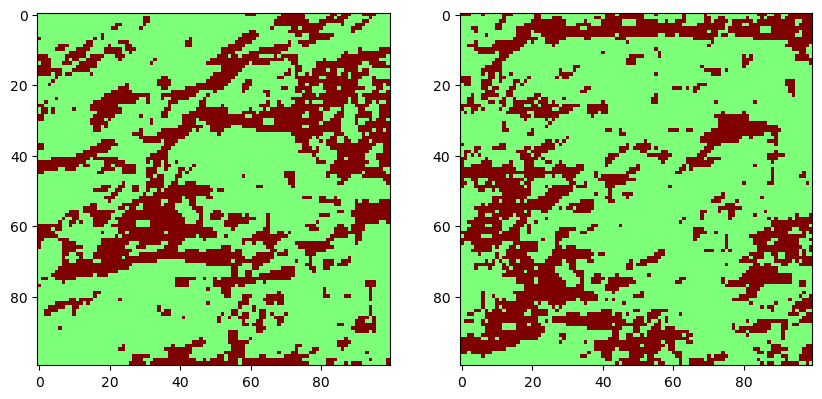

In [9]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bitis as bt


df = pd.read_csv(Path("/Users/arstanbek/Projects/fibrosis/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
df['Tissue size'] = df['Tissue size'].apply(
    lambda x: ast.literal_eval(x)
)

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2)

texture_ = texture[-100:, -100:]
simulation_tex = np.zeros(texture_.shape)
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=5,
                                 min_distance=0.0,
                                 min_known_pixels=10)

simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(texture_, vmin=0, vmax=2, cmap='jet')
ax[1].imshow(simulated_tex, vmin=0, vmax=2, cmap='jet')
plt.show()


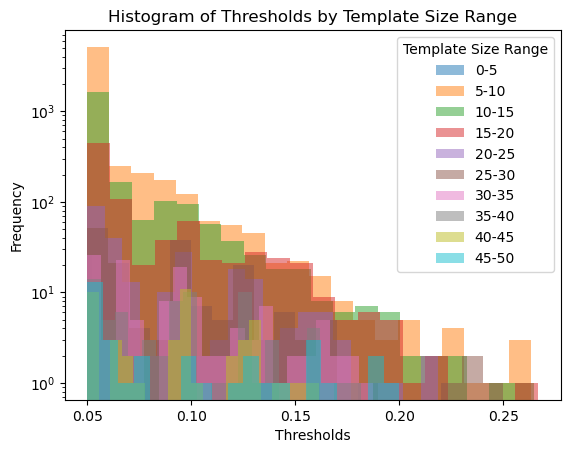

In [21]:
thr = np.array(simulation.template_matching._thresholds)
template_sizes = np.array(simulation.template_matching._template_size)

plt.figure()

for s_min, s_max in zip(np.arange(0, 50, 5), np.arange(5, 55, 5)):
    mask = (template_sizes[:, 0] >= s_min) & (template_sizes[:, 0] < s_max)
    plt.hist(thr[mask], bins=20, alpha=0.5, label=f"{s_min}-{s_max}")
plt.legend(title="Template Size Range")
plt.xlabel("Thresholds")
plt.ylabel("Frequency")
plt.title("Histogram of Thresholds by Template Size Range")
plt.yscale('log')
# plt.ylim([0.0, 0.01])
plt.show()

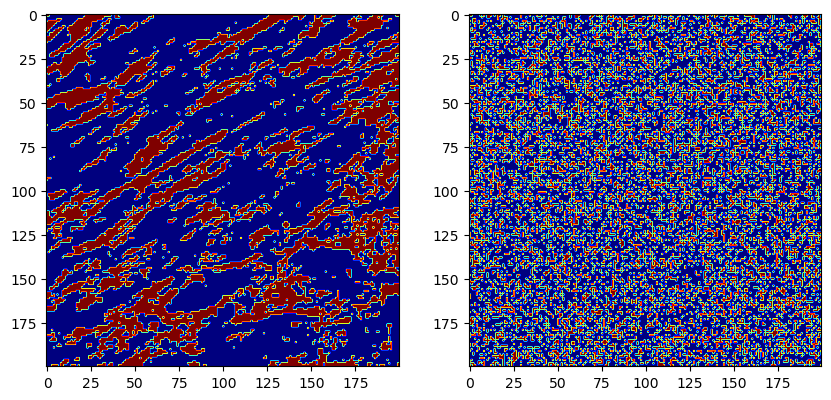

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(texture_, vmin=1, vmax=2, cmap='jet')
ax[1].imshow(simulated_tex, vmin=1, vmax=2, cmap='jet')
plt.show()